
Lafitte 2024: Legal innovatoins

Laffitte, S. (2024). The Historical Tax Havens Database (HTHD).

World Justice Project (WJP) Rule of Law Index.


VDEM Regime Type Data.
Coppedge, Michael, John Gerring, Carl Henrik Knutsen, Staffan I. Lindberg, Jan Teorell, David Altman, Fabio Angiolillo, Michael Bernhard, Agnes Cornell, M. Steven Fish, Linnea Fox, Lisa Gastaldi, Haakon Gjerløw, Adam Glynn, Ana Good God, Sandra Grahn, Allen Hicken, Katrin Kinzelbach, Joshua Krusell, Kyle L. Marquardt, Kelly McMann, Valeriya Mechkova, Juraj Medzihorsky, Natalia Natsika, Anja Neundorf, Pamela Paxton, Daniel Pemstein, Johannes von Römer, Brigitte Seim, Rachel Sigman, Svend-Erik Skaaning, Jeffrey Staton, Aksel Sundström, Marcus Tannenberg, Eitan Tzelgov, Yi-ting Wang, Felix Wiebrecht, Tore Wig, Steven Wilson and Daniel Ziblatt. 2025. "V-Dem [Country-Year/Country-Date] Dataset v15" Varieties of Democracy (V-Dem) Project. https://doi.org/10.23696/vdemds25

* World Inequality Database with data on wealth inequality.



# Data wrangling

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import powerlaw
import random

from collections import defaultdict
import scipy.stats as stats

# Set plot style
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

### ICIJ Data

Note: country_codes in ISO3 standard

In [26]:
icij_data_path = Path("datasets/ICIJ/data")

addresses_path = icij_data_path / "nodes-addresses.csv"
officers_path = icij_data_path / "nodes-officers.csv"
entities_path = icij_data_path / "nodes-entities.csv"
intermediaries_path = icij_data_path / "nodes-intermediaries.csv"
others_path = icij_data_path / "nodes-others.csv"
relationships_path = icij_data_path / "relationships.csv"

officers_df = pd.read_csv(officers_path)
entities_df = pd.read_csv(entities_path)
intermediaries_df = pd.read_csv(intermediaries_path)
others_df = pd.read_csv(others_path)
relationships_df = pd.read_csv(relationships_path)

/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_57351/1527137898.py:11: DtypeWarning: Columns (2,3,6,7,10,11,12,13,14,15,16,17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  entities_df = pd.read_csv(entities_path)
/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_57351/1527137898.py:14: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  relationships_df = pd.read_csv(relationships_path)


In [31]:
# Parse dates with explicit format and handle errors
# Handle date parsing with specific format DD-MMM-YYYY and error handling
for date_col in ["incorporation_date", "inactivation_date", "struck_off_date"]:
    entities_df[date_col] = pd.to_datetime(entities_df[date_col], format="%d-%b-%Y", errors="coerce")
    entities_df.loc[entities_df[date_col].dt.year > 2100, date_col] = pd.NaT
    print(f"Min date for {date_col}: {entities_df[date_col].min()}")
    print(f"Max date for {date_col}: {entities_df[date_col].max()}")

entities_df.head()

Min date for incorporation_date: 1865-10-26 00:00:00
Max date for incorporation_date: 2029-04-15 00:00:00
Min date for inactivation_date: 1930-11-30 00:00:00
Max date for inactivation_date: 2017-12-07 00:00:00
Min date for struck_off_date: 1919-02-02 00:00:00
Max date for struck_off_date: 2024-06-14 00:00:00


,node_id,name,original_name,former_name,jurisdiction,jurisdiction_description,company_type,address,internal_id,incorporation_date,...,struck_off_date,dorm_date,status,service_provider,ibcRUC,country_codes,countries,sourceID,valid_until,note
0,10000001,"TIANSHENG INDUSTRY AND TRADING CO., LTD.","TIANSHENG INDUSTRY AND TRADING CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1001256.0,2006-03-23,...,2013-02-15,NaN,Defaulted,Mossack Fonseca,25221,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
1,10000002,"NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.","NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1001263.0,2006-03-27,...,2014-02-15,NaN,Defaulted,Mossack Fonseca,25249,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
2,10000003,"HOTFOCUS CO., LTD.","HOTFOCUS CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1000896.0,2006-01-10,...,2012-02-15,NaN,Defaulted,Mossack Fonseca,24138,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
3,10000004,"SKY-BLUE GIFTS & TOYS CO., LTD.","SKY-BLUE GIFTS & TOYS CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1000914.0,2006-01-06,...,2009-02-15,NaN,Defaulted,Mossack Fonseca,24012,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
4,10000005,FORTUNEMAKER INVESTMENTS CORPORATION,FORTUNEMAKER INVESTMENTS CORPORATION,NaN,SAM,Samoa,NaN,LOYAL PORT LIMITED 8/F; CRAWFORD TOWER 99 JERV...,1001266.0,2006-04-19,...,2008-02-15,NaN,Changed agent,Mossack Fonseca,R25638,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN


In [38]:
entities_df["country_codes"].value_counts()

country_codes
MLT            84331
VGB            54932
HKG            38906
BRB            38430
CHE            37940
               ...  
BMU;HKG;MUS        1
BMU;SAU;USA        1
BHS;BMU;CHE        1
BMU;PRT;CHE        1
ARE;VGB;DJI        1
Name: count, Length: 1101, dtype: int64

### Historical Tax Havens Data

Grain: Country-Year. Haven and reform indicator

In [44]:
hthd_path = Path("datasets/legal_innovations_history/HTHD.csv")
hthd = pd.read_csv(hthd_path)
hthd_reforms = hthd[hthd["reform"] == 1]
hthd_reforms.sample(5)

,iso3,year,reform,reform_cumul,haven,Banking_cumul,Holding_cumul,IBC_cumul,Insurance_cumul,Corporate_cumul,Ship_cumul,Exempt_cumul,Individual_cumul,Treaty_cumul,Multiple_cumul,Other_cumul
6272,NIU,1994,1,1,1,0,0,1,0,0,0,0,0,0,0,0
8524,VUT,1992,1,4,1,1,0,1,0,0,1,2,0,0,1,0
1437,BLZ,1989,1,1,1,0,0,0,0,0,1,0,0,0,0,0
1731,VGB,1961,1,1,1,0,0,0,0,0,0,0,1,0,0,0
2998,HKG,1940,1,1,1,0,0,0,0,0,0,0,0,0,0,1


In [45]:
hthd_reforms[hthd_reforms["iso3"] == "NIU"]

,iso3,year,reform,reform_cumul,haven,Banking_cumul,Holding_cumul,IBC_cumul,Insurance_cumul,Corporate_cumul,Ship_cumul,Exempt_cumul,Individual_cumul,Treaty_cumul,Multiple_cumul,Other_cumul
6272,NIU,1994,1,1,1,0,0,1,0,0,0,0,0,0,0,0


/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_57351/4160682395.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_entities['incorporation_year'] = country_entities['incorporation_date'].dt.year


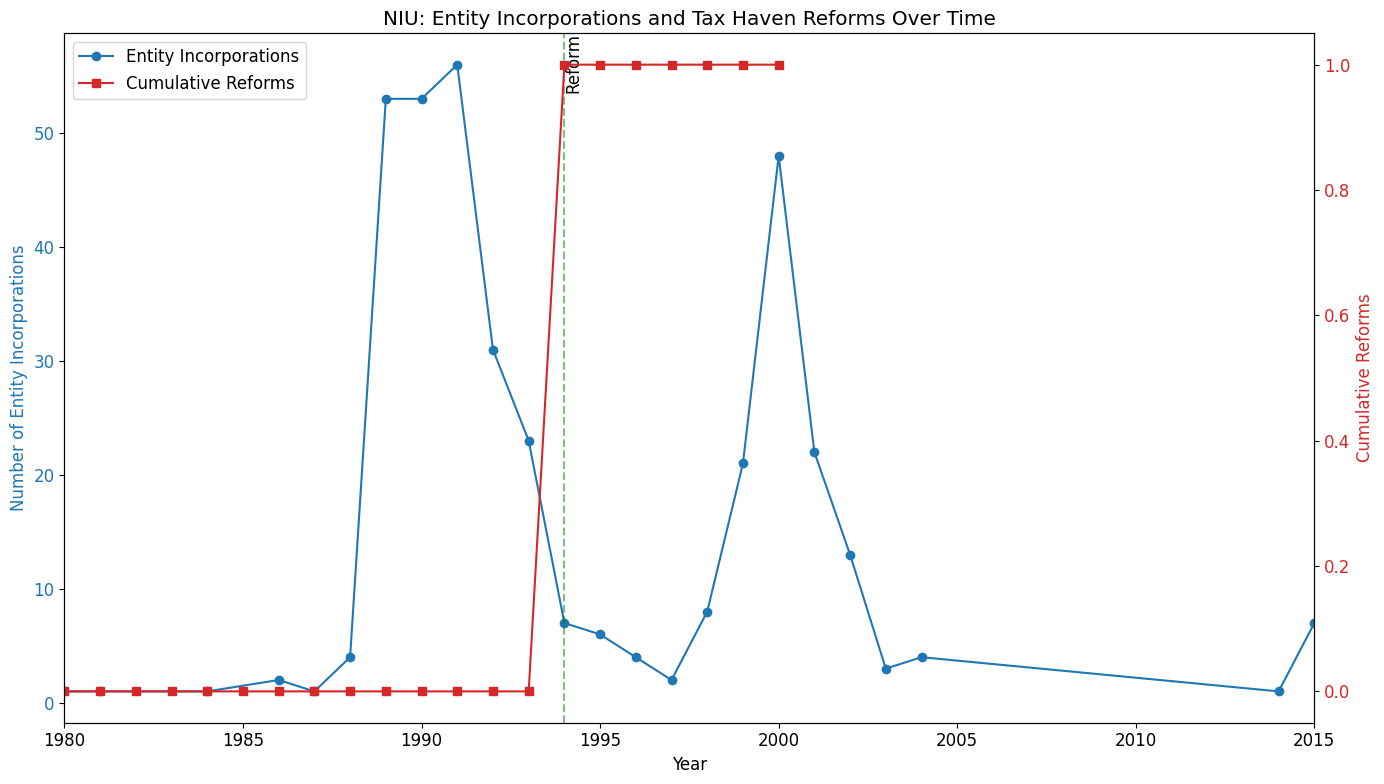

Total number of NIU entities in dataset: 372
Year range: 1980 to 2015
Years with reforms: 1994
Total number of reforms: 1


In [46]:
def plot_entity_reforms(iso3_code, entities_df, hthd_df):
    # Filter entities for specified jurisdiction
    country_entities = entities_df[entities_df['country_codes'] == iso3_code]
    
    # Extract year from incorporation date
    country_entities['incorporation_year'] = country_entities['incorporation_date'].dt.year
    
    # Count incorporations by year
    incorporations_by_year = country_entities.groupby('incorporation_year').size().reset_index(name='count')
    
    # Filter tax haven data for specified country
    country_hthd = hthd_df[hthd_df['iso3'] == iso3_code]
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plot incorporations on primary y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Entity Incorporations', color=color)
    line1 = ax1.plot(incorporations_by_year['incorporation_year'], 
                     incorporations_by_year['count'], 
                     color=color, 
                     marker='o',
                     label='Entity Incorporations')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Create secondary y-axis for reforms
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Cumulative Reforms', color=color)
    line2 = ax2.plot(country_hthd['year'], 
                     country_hthd['reform_cumul'], 
                     color=color, 
                     marker='s',
                     label='Cumulative Reforms')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Add vertical lines for reform years
    reform_years = country_hthd[country_hthd['reform'] == 1]['year']
    for year in reform_years:
        ax1.axvline(x=year, color='green', linestyle='--', alpha=0.5)
        ax1.text(year, ax1.get_ylim()[1], 'Reform', rotation=90, verticalalignment='top')
    
    # Add title and legend
    plt.title(f'{iso3_code}: Entity Incorporations and Tax Haven Reforms Over Time')
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')
    
    # Set x-axis limits to focus on relevant years
    ax1.set_xlim(1980, 2015)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Total number of {iso3_code} entities in dataset: {len(country_entities)}")
    print(f"Year range: {country_entities['incorporation_year'].min()} to {country_entities['incorporation_year'].max()}")
    print(f"Years with reforms: {', '.join(map(str, reform_years))}")
    print(f"Total number of reforms: {len(reform_years)}")

# Example usage:
plot_entity_reforms('NIU', entities_df, hthd)

In [54]:
# Totla incorporations across all countries
# Find entities with multiple country codes (containing semicolons)
multi_country_entities = entities_df[entities_df['country_codes'].str.contains(';', na=False)]

# Display the results
print(f"Number of entities with multiple country codes: {len(multi_country_entities)}")
print("\nSample of multi-country entities:")
print(multi_country_entities[['name', 'country_codes']].head())

# Show distribution of number of countries per entity
multi_country_entities['num_countries'] = multi_country_entities['country_codes'].str.count(';') + 1
print("\nDistribution of number of countries per entity:")
print(multi_country_entities['num_countries'].value_counts().sort_index())


entities_df.shape

Number of entities with multiple country codes: 54432

Sample of multi-country entities:
                   name country_codes
213967       ZODIAK LTD       VGB;CYP
213968        Zven Ltd.       XXX;VGB
213969   Anson 11A Ltd.       SGP;VGB
213970        GIADA LTD       CYP;VGB
213971  Scott D. Howard       USA;XXX

Distribution of number of countries per entity:
num_countries
2    54130
3      287
4       15
Name: count, dtype: int64


/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_57351/4080743100.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_country_entities['num_countries'] = multi_country_entities['country_codes'].str.count(';') + 1


(814344, 22)

In [60]:
entities_df.head()

,node_id,name,original_name,former_name,jurisdiction,jurisdiction_description,company_type,address,internal_id,incorporation_date,...,dorm_date,status,service_provider,ibcRUC,country_codes,countries,sourceID,valid_until,note,incorporation_year
0,10000001,"TIANSHENG INDUSTRY AND TRADING CO., LTD.","TIANSHENG INDUSTRY AND TRADING CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1001256.0,2006-03-23,...,NaN,Defaulted,Mossack Fonseca,25221,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN,2006.0
1,10000002,"NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.","NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1001263.0,2006-03-27,...,NaN,Defaulted,Mossack Fonseca,25249,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN,2006.0
2,10000003,"HOTFOCUS CO., LTD.","HOTFOCUS CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1000896.0,2006-01-10,...,NaN,Defaulted,Mossack Fonseca,24138,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN,2006.0
3,10000004,"SKY-BLUE GIFTS & TOYS CO., LTD.","SKY-BLUE GIFTS & TOYS CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1000914.0,2006-01-06,...,NaN,Defaulted,Mossack Fonseca,24012,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN,2006.0
4,10000005,FORTUNEMAKER INVESTMENTS CORPORATION,FORTUNEMAKER INVESTMENTS CORPORATION,NaN,SAM,Samoa,NaN,LOYAL PORT LIMITED 8/F; CRAWFORD TOWER 99 JERV...,1001266.0,2006-04-19,...,NaN,Changed agent,Mossack Fonseca,R25638,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN,2006.0


/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_57351/1219992589.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entities_valid['incorporation_year'] = entities_valid['incorporation_year'].astype(int)


(1980.0, 2020.0)

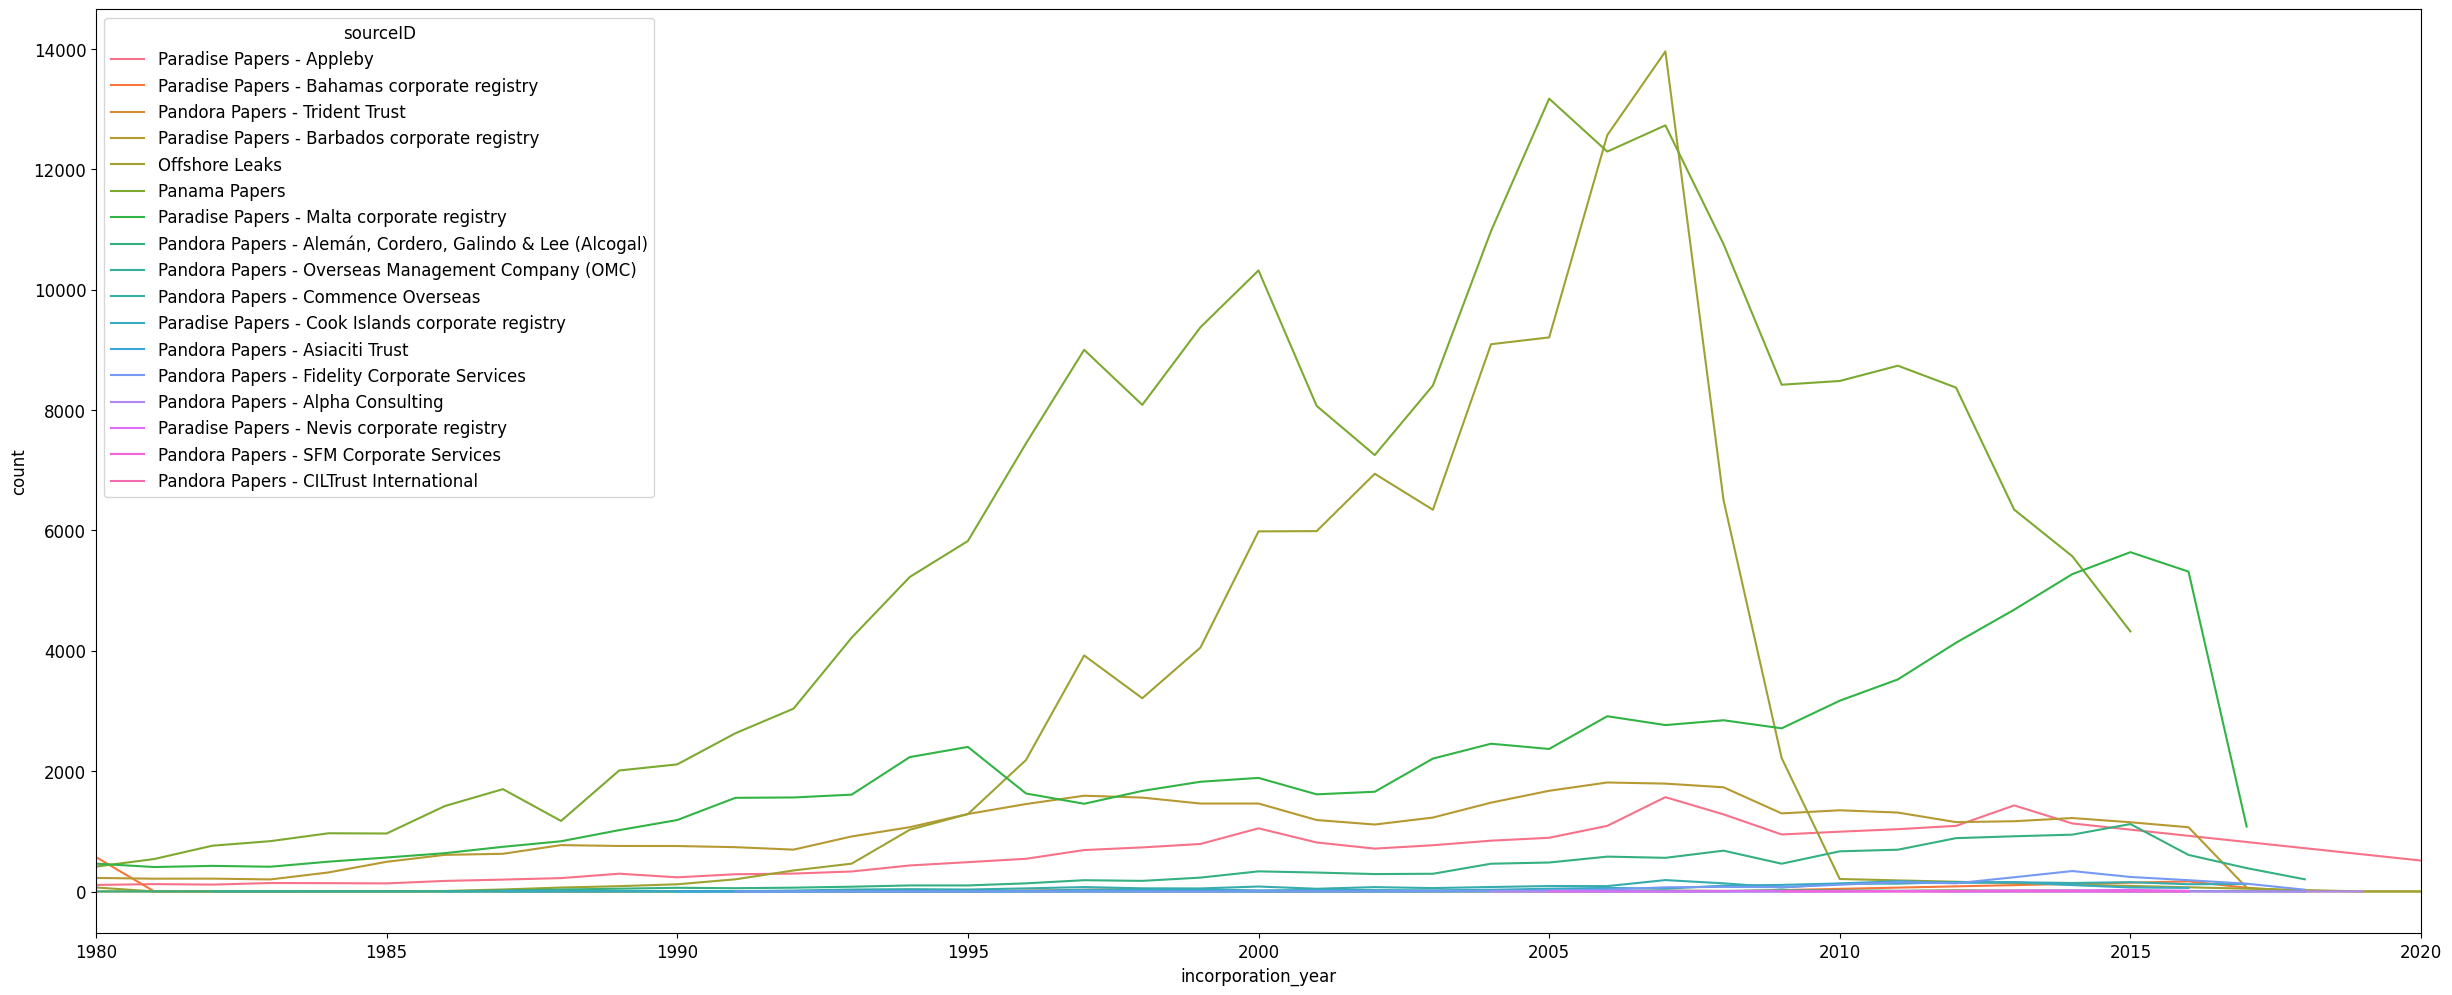

In [63]:
entities_df['incorporation_year'] = entities_df['incorporation_date'].dt.year
entities_valid = entities_df.dropna(subset=['incorporation_year', 'country_codes'])
entities_valid['incorporation_year'] = entities_valid['incorporation_year'].astype(int)

agg_counts = (
    entities_valid.groupby(['incorporation_year', 'sourceID'])
    .size().reset_index(name='count')
)

plt.figure(figsize=(30, 12))
sns.lineplot(x='incorporation_year', y='count', data=agg_counts, hue='sourceID')
plt.xlim([1980, 2020])


/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_57351/2751480780.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entities_valid['incorporation_year'] = entities_valid['incorporation_year'].astype(int)


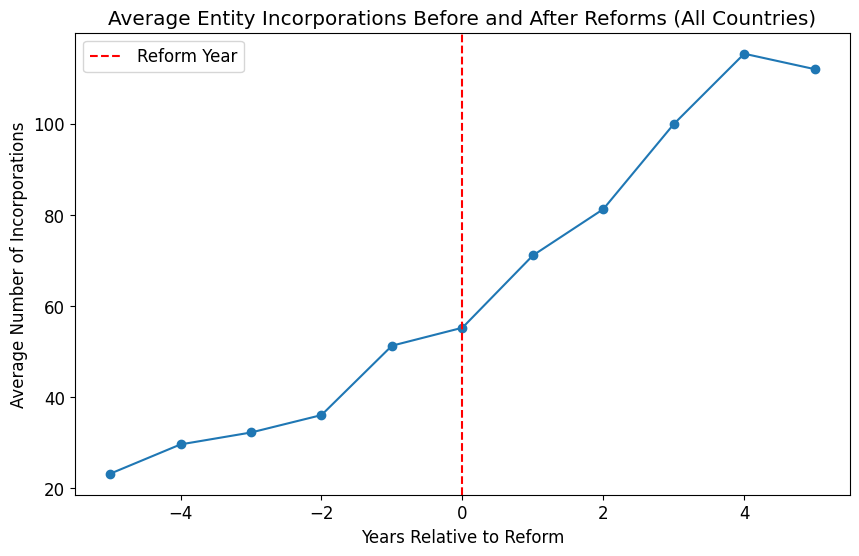

In [79]:
window = 5  # years before and after reform

# Prepare: extract year for all entities
entities_df['incorporation_year'] = entities_df['incorporation_date'].dt.year

# Only keep entities with a valid year
entities_valid = entities_df.dropna(subset=['incorporation_year', 'jurisdiction'])
entities_valid['incorporation_year'] = entities_valid['incorporation_year'].astype(int)

# Prepare a list to collect event windows
event_windows = []

# Loop over all country-reform events
for _, row in hthd[hthd['reform'] == 1].iterrows():
    country = row['iso3']
    reform_year = row['year']
    # For each event, get incorporations in window around reform
    for rel_year in range(-window, window+1):
        year = reform_year + rel_year
        count = entities_valid[
            (entities_valid['jurisdiction'] == country) &
            (entities_valid['incorporation_year'] == year)
        ].shape[0]
        event_windows.append({'country': country, 'reform_year': reform_year, 'event_time': rel_year, 'incorporations': count})

# Convert to DataFrame
event_df = pd.DataFrame(event_windows)

# Group by event_time and average across all events
event_avg = event_df.groupby('event_time')['incorporations'].mean().reset_index()

# Plot
plt.figure(figsize=(10,6))
plt.plot(event_avg['event_time'], event_avg['incorporations'], marker='o')
plt.axvline(0, color='red', linestyle='--', label='Reform Year')
plt.title('Average Entity Incorporations Before and After Reforms (All Countries)')
plt.xlabel('Years Relative to Reform')
plt.ylabel('Average Number of Incorporations')
plt.legend()
plt.show()